# Intro

We train mixture density network (https://publications.aston.ac.uk/373/1/NCRG_94_004.pdf) on 1D toy data. As target distribution we choose the individual modes to be gaussians.

# Imports

In [77]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import keras.backend as K
from keras.models import Model
from keras.layers import Dense, Input, Lambda, Concatenate
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

%matplotlib inline

# Create toy dataset

One dimensional sine function with noise from two different gaussians with zero mean

In [359]:
N = 4000
N_val = 1000
max_tr = 20
min_val = 0
max_val = 20
sig1 = 0.1
sig2 = 0.3

# Training
X = np.random.uniform(0, max_tr, N)
Y = np.sin(X) + np.random.normal(loc=0, scale=sig1, size=N) + np.random.normal(loc=0, scale=sig2, size=N)

# Validation
X_val = np.random.uniform(min_val, max_val, N_val)
Y_val = np.sin(X_val) + np.random.normal(loc=0, scale=sig1, size=N_val) + np.random.normal(loc=0, scale=sig2, size=N_val)

Visualize data

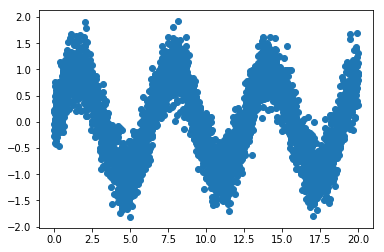

In [263]:
plt.figure()
plt.scatter(X, Y)
plt.show()

# Define model

Model can be used to train a normal dense network or a mixture density network

In [500]:
# Hyperparameters
lr = 0.001
lr_mdn = 0.001
batch_size = 128
epochs = 1000
patience = 20
modes = 1

In [486]:
def mdn_loss(y_true, y_pred):
    """
    Computes mdn loss
    
    args:
        y_true: labels plus dummy labels for std and weight 
        y_pred: prediction
        
    returns:
        loss
    """
    
    targets = y_true[:, :1]
    means = y_pred[:, :modes]
    std = tf.square(tf.exp(y_pred[:, modes:2*modes]))
    weights = y_pred[:, 2*modes:3*modes]
    
    modes_prob = []
    for i in range(modes):
        diff = tf.subtract(targets, means[:, i:(i+1)])
        m_loss_log = -1*tf.divide(tf.square(diff), 2*std[:, i:(i+1)]) - tf.sqrt(2*np.pi*std[:, i:(i+1)]) + tf.log(weights[:, i:(i+1)])
        modes_prob.append(m_loss_log)
        
    prob = tf.concat(modes_prob, axis=1)
    
    loss = tf.reduce_logsumexp(prob, axis=1)
    loss = tf.reduce_mean(loss, axis=0)
    
    return (-1)*loss

In [282]:
def get_model(mdn=False):
    
    inp = Input(shape=(1,))
    dense = Dense(100, activation='relu')(inp)
    dense = Dense(100, activation='relu')(dense)
    dense = Dense(100, activation='relu')(dense)
    
    if not mdn:
        out = Dense(1)(dense)
    else:
        out_mean = Dense(modes)(dense)
        
        out_std = Dense(modes)(dense)
#         out_std = Lambda(lambda x: tf.abs(x))(out_std)
        
        out_weights = Dense(modes, activation='softmax')(dense)
#         out_weights = Lambda(lambda x: tf.abs(x)/(tf.reduce_sum(tf.abs(x))+1e-12))(out_weights)
        
        out = Concatenate(axis=1)([out_mean, out_std, out_weights])
    
    model = Model(inputs=[inp], outputs=[out])
    
    if not mdn:
        model.compile(Adam(lr=lr), loss='mse')
    else:
        model.compile(Adam(lr=lr_mdn), loss=mdn_loss)
    
    return model

Fit normal dense model to data

In [501]:
model = get_model(mdn=False)

In [502]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_83 (InputLayer)        (None, 1)                 0         
_________________________________________________________________
dense_400 (Dense)            (None, 100)               200       
_________________________________________________________________
dense_401 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_402 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_403 (Dense)            (None, 1)                 101       
Total params: 20,501
Trainable params: 20,501
Non-trainable params: 0
_________________________________________________________________


In [503]:
model.fit(
    x = X,
    y = Y,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=[X_val, Y_val],
    callbacks = [
        EarlyStopping(patience=patience)
    ]
)

Train on 4000 samples, validate on 1000 samples
Epoch 1/1000
4000/4000 [==============================] - 4s 1ms/step - loss: 1.7358 - val_loss: 0.6116
Epoch 2/1000
4000/4000 [==============================] - 0s 44us/step - loss: 0.5917 - val_loss: 0.6055
Epoch 3/1000
4000/4000 [==============================] - 0s 52us/step - loss: 0.5818 - val_loss: 0.5980
Epoch 4/1000
4000/4000 [==============================] - 0s 48us/step - loss: 0.5806 - val_loss: 0.5998
Epoch 5/1000
4000/4000 [==============================] - 0s 50us/step - loss: 0.5774 - val_loss: 0.5935
Epoch 6/1000
4000/4000 [==============================] - 0s 55us/step - loss: 0.5729 - val_loss: 0.5900
Epoch 7/1000
4000/4000 [==============================] - 0s 46us/step - loss: 0.5748 - val_loss: 0.5845
Epoch 8/1000
4000/4000 [==============================] - 0s 53us/step - loss: 0.5673 - val_loss: 0.5846
Epoch 9/1000
4000/4000 [==============================] - 0s 53us/step - loss: 0.5580 - val_loss: 0.5748
Epoch 10

Epoch 78/1000
4000/4000 [==============================] - 0s 45us/step - loss: 0.3413 - val_loss: 0.3595
Epoch 79/1000
4000/4000 [==============================] - 0s 44us/step - loss: 0.3400 - val_loss: 0.3517
Epoch 80/1000
4000/4000 [==============================] - 0s 41us/step - loss: 0.3377 - val_loss: 0.3574
Epoch 81/1000
4000/4000 [==============================] - 0s 41us/step - loss: 0.3350 - val_loss: 0.3546
Epoch 82/1000
4000/4000 [==============================] - 0s 44us/step - loss: 0.3332 - val_loss: 0.3702
Epoch 83/1000
4000/4000 [==============================] - 0s 45us/step - loss: 0.3291 - val_loss: 0.3564
Epoch 84/1000
4000/4000 [==============================] - 0s 45us/step - loss: 0.3274 - val_loss: 0.3424
Epoch 85/1000
4000/4000 [==============================] - 0s 43us/step - loss: 0.3246 - val_loss: 0.3420
Epoch 86/1000
4000/4000 [==============================] - 0s 44us/step - loss: 0.3208 - val_loss: 0.3406
Epoch 87/1000
4000/4000 [=====================

Epoch 155/1000
4000/4000 [==============================] - 0s 47us/step - loss: 0.1248 - val_loss: 0.1161
Epoch 156/1000
4000/4000 [==============================] - 0s 46us/step - loss: 0.1167 - val_loss: 0.1018
Epoch 157/1000
4000/4000 [==============================] - 0s 44us/step - loss: 0.1179 - val_loss: 0.1334
Epoch 158/1000
4000/4000 [==============================] - 0s 65us/step - loss: 0.1286 - val_loss: 0.1074
Epoch 159/1000
4000/4000 [==============================] - 0s 53us/step - loss: 0.1246 - val_loss: 0.1261
Epoch 160/1000
4000/4000 [==============================] - 0s 59us/step - loss: 0.1166 - val_loss: 0.0979
Epoch 161/1000
4000/4000 [==============================] - 0s 49us/step - loss: 0.1137 - val_loss: 0.1363
Epoch 162/1000
4000/4000 [==============================] - 0s 51us/step - loss: 0.1151 - val_loss: 0.1165
Epoch 163/1000
4000/4000 [==============================] - 0s 46us/step - loss: 0.1128 - val_loss: 0.1006
Epoch 164/1000
4000/4000 [===========

Visualize prediction

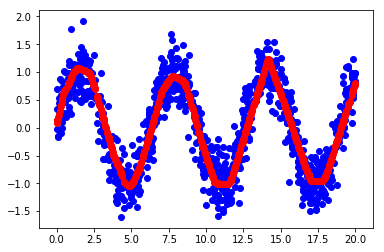

In [504]:
preds = model.predict(X_val)

plt.figure()
plt.scatter(X_val, Y_val, color='b')
plt.scatter(X_val, preds[:, 0], color='r')
plt.show()

Fit mixture density network to model

In [511]:
model_mdn = get_model(mdn=True)

In [512]:
model_mdn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_85 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_410 (Dense)               (None, 100)          200         input_85[0][0]                   
__________________________________________________________________________________________________
dense_411 (Dense)               (None, 100)          10100       dense_410[0][0]                  
__________________________________________________________________________________________________
dense_412 (Dense)               (None, 100)          10100       dense_411[0][0]                  
__________________________________________________________________________________________________
dense_413 

In [513]:
Y_mdn = np.concatenate([np.reshape(Y, (Y.shape[0], 1)), np.zeros((Y.shape[0], modes*3-1))], axis=1)
Y_mdn_val = np.concatenate([np.reshape(Y_val, (Y_val.shape[0], 1)), np.zeros((Y_val.shape[0], modes*3-1))], axis=1)

model_mdn.fit(
    x = X,
    y = Y_mdn,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=[X_val, Y_mdn_val],
    callbacks = [
        EarlyStopping(patience=patience)
    ]
)

Train on 4000 samples, validate on 1000 samples
Epoch 1/1000
4000/4000 [==============================] - 4s 1ms/step - loss: 2.5991 - val_loss: 2.4469
Epoch 2/1000
4000/4000 [==============================] - 0s 65us/step - loss: 2.3598 - val_loss: 2.3283
Epoch 3/1000
4000/4000 [==============================] - 0s 64us/step - loss: 2.2984 - val_loss: 2.3506
Epoch 4/1000
4000/4000 [==============================] - 0s 68us/step - loss: 2.2702 - val_loss: 2.2760
Epoch 5/1000
4000/4000 [==============================] - 0s 69us/step - loss: 2.2542 - val_loss: 2.2439
Epoch 6/1000
4000/4000 [==============================] - 0s 69us/step - loss: 2.2113 - val_loss: 2.2416
Epoch 7/1000
4000/4000 [==============================] - 0s 64us/step - loss: 2.1958 - val_loss: 2.2458
Epoch 8/1000
4000/4000 [==============================] - 0s 68us/step - loss: 2.1768 - val_loss: 2.2113
Epoch 9/1000
4000/4000 [==============================] - 0s 65us/step - loss: 2.1588 - val_loss: 2.1956
Epoch 10

Epoch 78/1000
4000/4000 [==============================] - 0s 67us/step - loss: 1.6654 - val_loss: 1.6853
Epoch 79/1000
4000/4000 [==============================] - 0s 62us/step - loss: 1.6464 - val_loss: 1.6687
Epoch 80/1000
4000/4000 [==============================] - 0s 68us/step - loss: 1.6576 - val_loss: 1.7264
Epoch 81/1000
4000/4000 [==============================] - 0s 78us/step - loss: 1.6717 - val_loss: 1.6641
Epoch 82/1000
4000/4000 [==============================] - 0s 76us/step - loss: 1.6259 - val_loss: 1.6595
Epoch 83/1000
4000/4000 [==============================] - 0s 73us/step - loss: 1.6389 - val_loss: 1.7040
Epoch 84/1000
4000/4000 [==============================] - 0s 62us/step - loss: 1.6498 - val_loss: 1.6683
Epoch 85/1000
4000/4000 [==============================] - 0s 65us/step - loss: 1.6206 - val_loss: 1.6241
Epoch 86/1000
4000/4000 [==============================] - 0s 67us/step - loss: 1.6138 - val_loss: 1.6266
Epoch 87/1000
4000/4000 [=====================

Epoch 155/1000
4000/4000 [==============================] - 0s 65us/step - loss: 1.3168 - val_loss: 1.2792
Epoch 156/1000
4000/4000 [==============================] - 0s 60us/step - loss: 1.3327 - val_loss: 1.2706
Epoch 157/1000
4000/4000 [==============================] - 0s 57us/step - loss: 1.3192 - val_loss: 1.2841
Epoch 158/1000
4000/4000 [==============================] - 0s 61us/step - loss: 1.3188 - val_loss: 1.3091
Epoch 159/1000
4000/4000 [==============================] - 0s 61us/step - loss: 1.3515 - val_loss: 1.2934
Epoch 160/1000
4000/4000 [==============================] - 0s 70us/step - loss: 1.3367 - val_loss: 1.3001
Epoch 161/1000
4000/4000 [==============================] - 0s 62us/step - loss: 1.3468 - val_loss: 1.2817
Epoch 162/1000
4000/4000 [==============================] - 0s 67us/step - loss: 1.3282 - val_loss: 1.3089
Epoch 163/1000
4000/4000 [==============================] - 0s 67us/step - loss: 1.3512 - val_loss: 1.2810
Epoch 164/1000
4000/4000 [===========

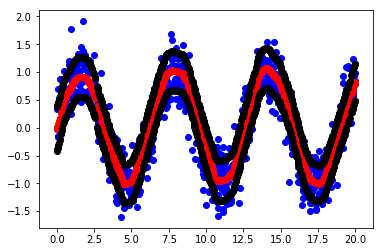

In [514]:
preds_mdn = model_mdn.predict(X_val)

preds_mdn_means = preds_mdn[:, :modes]
preds_mdn_stds = preds_mdn[:, modes:2*modes]
preds_mdn_weights = preds_mdn[:, 2*modes:3*modes]

preds_mdn_final = np.sum(preds_mdn_means*preds_mdn_weights, axis=1)
std_mdn_final = np.exp(np.sum(preds_mdn_stds*preds_mdn_weights, axis=1))

plt.figure()
plt.scatter(X_val, Y_val, color='b')
plt.scatter(X_val, preds_mdn_final, color='r')
plt.scatter(X_val, preds_mdn_final + std_mdn_final, color='k')
plt.scatter(X_val, preds_mdn_final - std_mdn_final, color='k')
plt.show()

In [515]:
print('Mean Sigmas:')
print(np.exp(preds_mdn_stds.mean(axis=0)))
print('Mean Weights:')
print(preds_mdn_weights.mean(axis=0))

Mean Sigmas:
[0.34748513]
Mean Weights:
[1.]


# Error comparison

Comparing the errors of normal model vs. mdn

In [516]:
error = np.mean(np.abs(preds[:,0] - Y_val))
error_mdn = np.mean(np.abs(preds_mdn_final - Y_val))

print('Error normal: ' + str(error))
print('Error MDN: ' + str(error_mdn))

Error normal: 0.25819997780534876
Error MDN: 0.25367289983282365


# Visualize uncertainty estimate

Variance depending on prediction error

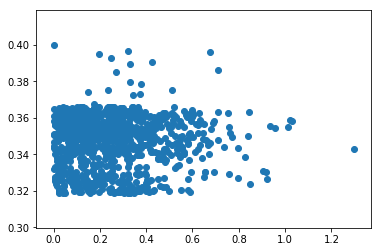

In [517]:
plt.figure()
plt.scatter(np.abs(preds_mdn_final - Y_val), std_mdn_final)
plt.show()

In [518]:
np.sqrt(0.3**2 + 0.1**2)

0.31622776601683794